<a href="https://colab.research.google.com/github/KKacper48/computer-vision-course/blob/main/02_document_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Document Scanner

Narzędzie polegające na ekstrakcji z obrazu wartościowych informacji takich jak różnego rodzaju dokumenty (paragony, faktury, umowy, itd.)

Jest to zadanie z kategorii Computer Vision. W tym celu wykorzystamy bibliotekę OpenCV.

Import bibliotek

In [1]:
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
import numpy as np
from numpy.linalg import norm
import imutils
import cv2
cv2.__version__

'4.6.0'

Wczytanie obrazu z dokumentem

In [2]:
image = cv2.imread('paragon_1.jpg')
image.shape

(600, 450, 3)

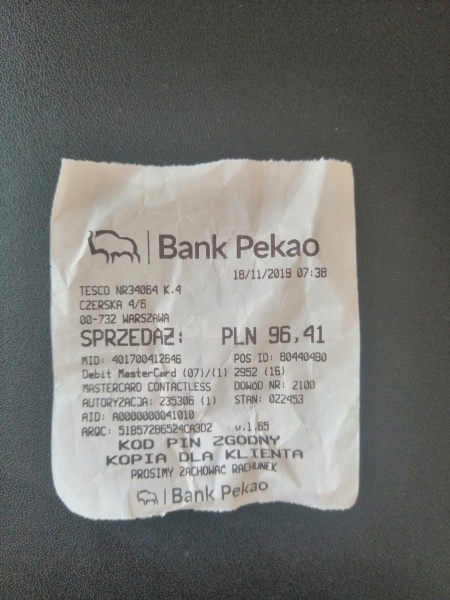

In [3]:
cv2_imshow(image)

Standaryzacja rozmiaru

In [4]:
# zachowamy kopię oryginalnego obrazu do późniejszych przekształceń
original_image = image.copy()

# zachowamy proporcję oryginalnego obrazu
ratio = image.shape[0] / 500.0

#zmiana rozmiaru do wysokości 500 pikseli
image = imutils.resize(image, height=500)
image.shape

(500, 375, 3)

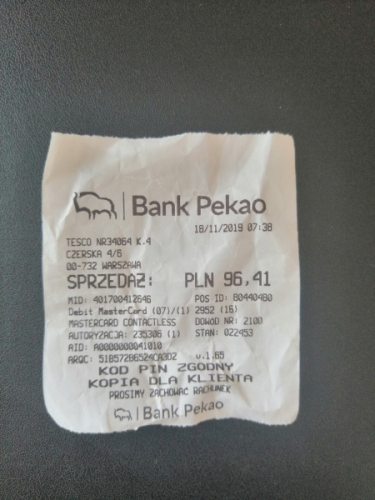

In [5]:
cv2_imshow(image)

Konwersja obrazu do skali szarości

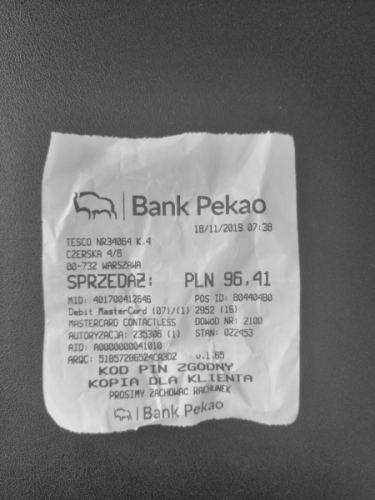

In [6]:
gray_image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

Detekcja krawędzi

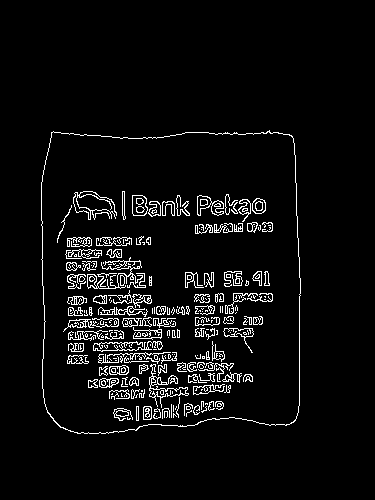

In [7]:
edges = cv2.Canny(gray_image, threshold1=75, threshold2=200)
cv2_imshow(edges)

Rozmycie

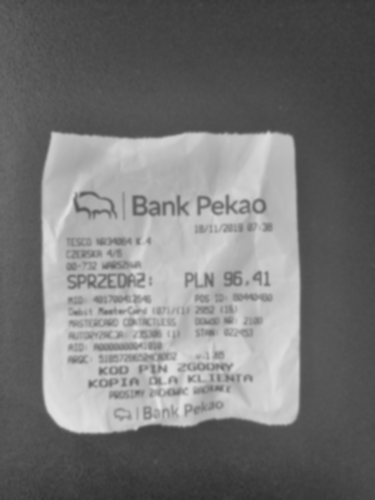

In [8]:
gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
cv2_imshow(gray_image)

Detekcja krawędzi po rozmyciu

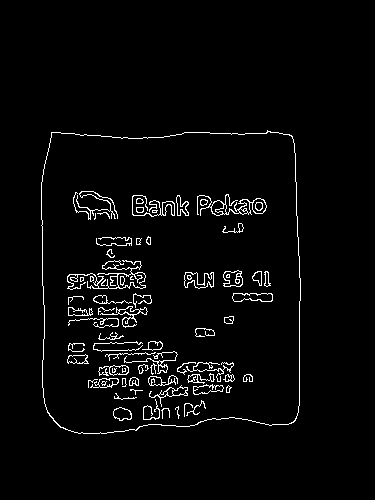

In [9]:
edges = cv2.Canny(gray_image, threshold1=75, threshold2=200)
cv2_imshow(edges)

Znalezienie konturu dokumentów

Zadanie sprowadza się do wykrycia wierzchołków dokumentu. Zakładamy, że dokument stanowi główny obszar zdęcia lub jest dobrze widoczny (tak jak pokazano na przykładzie, wszystkie cztery wierzchołki dokumentu należą do zdjęcia)

Naiwnie założymy, że najdłuższy kontur wykryty na zdjęciu to właśnie kontur szukanego dokumentu.

In [10]:
contours = cv2.findContours(image=edges.copy(), mode=cv2.RETR_LIST, 
                            method=cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Liczba wszystkich wyszukanych punktów (kontur): {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

for contour in contours:
  print(len(contour))

Liczba wszystkich wyszukanych punktów (kontur): 135
217
215
189
356
83


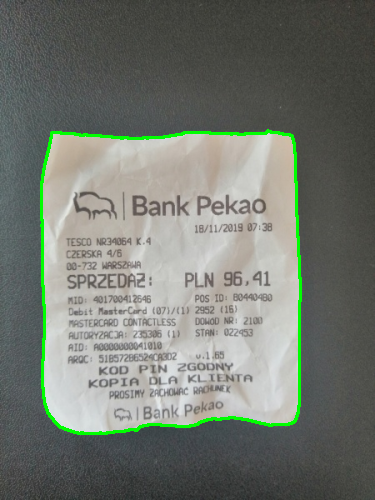

In [11]:
cnt1 = cv2.drawContours(image.copy(), [contours[0]], -1, (0, 255, 0), 2)
cv2_imshow(cnt1)

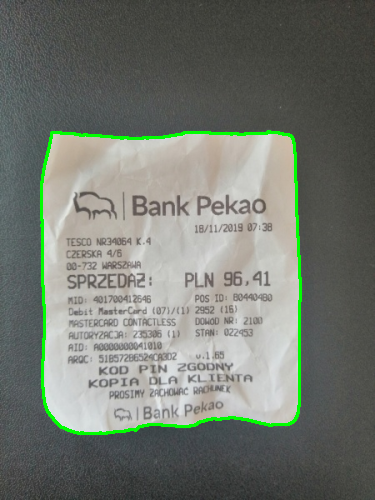

In [12]:
cnt2 = cv2.drawContours(image.copy(), [contours[1]], -1, (0, 255, 0), 2)
cv2_imshow(cnt2)

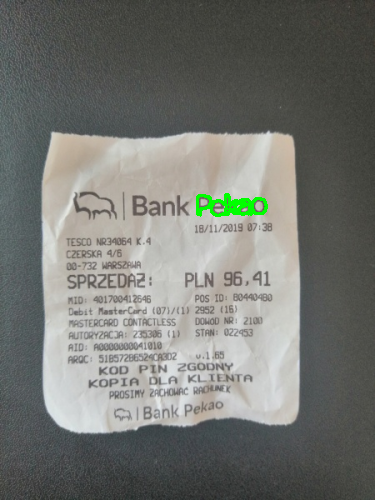

In [13]:
cnt3 = cv2.drawContours(image.copy(), [contours[2]], -1, (0, 255, 0), 2)
cv2_imshow(cnt3)

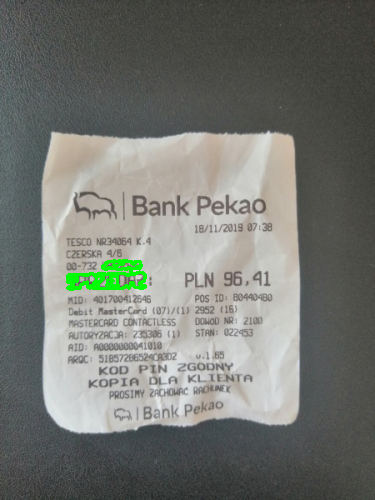

In [14]:
cnt4 = cv2.drawContours(image.copy(), [contours[3]], -1, (0, 255, 0), 2)
cv2_imshow(cnt4)

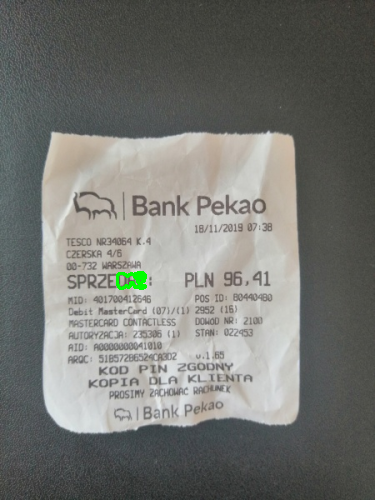

In [15]:
cnt5 = cv2.drawContours(image.copy(), [contours[4]], -1, (0, 255, 0), 2)
cv2_imshow(cnt5)

In [16]:
for contour in contours:
  print('Sprawdzanie...')
  # obliczymy obwód każdej wyszukanej figury
  perimeter = cv2.arcLength(curve=contour, closed=True)

  # przybliżenie krzywej wielokąta (w maszym przypadku prostokąt) z określoną pozycją
  approx = cv2.approxPolyDP(curve=contour, epsilon=0.02 * perimeter, closed=True)

  if len(approx) == 4:
    screen_contour = approx
    break

print(screen_contour)

Sprawdzanie...
[[[291 135]]

 [[ 51 132]]

 [[ 60 427]]

 [[295 420]]]


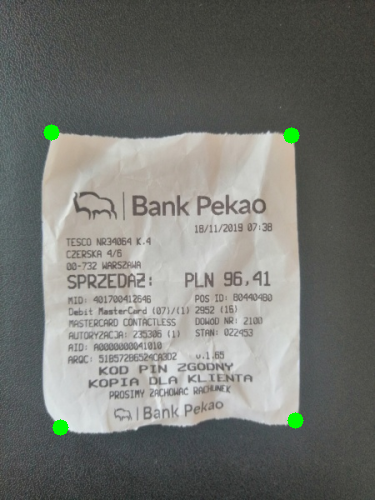

In [17]:
#wyświetlenie znalezionych wierzchołków
cv2.drawContours(image, contours=screen_contour, contourIdx=-1, color=(0, 255, 0), thickness=15)
cv2_imshow(image)

Ekstrakcja wierzchołków

In [18]:
points = screen_contour.reshape(4, 2)
points = points * ratio
points

array([[349.2, 162. ],
       [ 61.2, 158.4],
       [ 72. , 512.4],
       [354. , 504. ]])

In [19]:
rectangle = np.zeros((4, 2), dtype='float32')
rectangle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [20]:
total = points.sum(axis=1)

rectangle[0] = points[np.argmin(total)]
rectangle[2] = points[np.argmax(total)]
rectangle

array([[ 61.2, 158.4],
       [  0. ,   0. ],
       [354. , 504. ],
       [  0. ,   0. ]], dtype=float32)

In [21]:
difference = np.diff(points, axis=1)
rectangle[1] = points[np.argmin(difference)]
rectangle[3] = points[np.argmax(difference)]
rectangle

array([[ 61.2, 158.4],
       [349.2, 162. ],
       [354. , 504. ],
       [ 72. , 512.4]], dtype=float32)

In [22]:
(a, b, c, d) = rectangle

width1 = norm(c - d)
width2 = norm(b - a)
max_width = max(int(width1), int(width2))

height1 = norm(b - c)
height2 = norm(a - d)
max_height = max(int(height1), int(height2))

print(f'max_width: {max_width}')
print(f'max_height: {max_height}')

max_width: 288
max_height: 354


In [23]:
vertices = np.array([
                   [0,0],
                   [max_width - 1, 0],
                   [max_width - 1, max_height - 1],
                   [0, max_height - 1]
                    
], dtype='float32')

vertices

array([[  0.,   0.],
       [287.,   0.],
       [287., 353.],
       [  0., 353.]], dtype=float32)

Transformacja wyszukanego dokumentu do obrazu: getPerspectiveTransform() - zwraca macierz transformacji

In [24]:
# macierz transformacji 3x3
M = cv2.getPerspectiveTransform(rectangle, vertices)
M

array([[ 9.47714238e-01, -2.89133112e-02, -5.34202438e+01],
       [-1.20274799e-02,  9.62196799e-01, -1.51675885e+02],
       [-1.16837073e-04, -5.27577240e-05,  1.00000000e+00]])

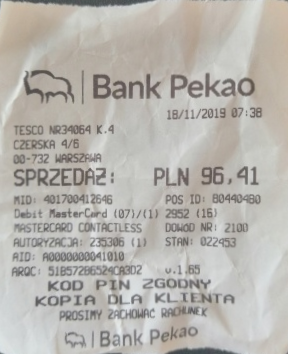

In [25]:
# przekształcenie dokumentu do obrazu
out = cv2.warpPerspective(src=original_image, M=M, dsize=(max_width, max_height))
cv2_imshow(out)

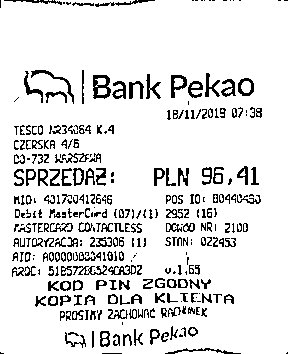

In [26]:
# konwersja do skali szarości
out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)

# obliczenie maski progowej na podstawie sąsiedztwa pikseli
T = threshold_local(image=out, block_size=11, offset=10, method='gaussian')
out = (out > T).astype('uint8') * 255
cv2_imshow(out)